In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/en-fr-translation-dataset/en-fr.csv


In [2]:
%rm -r transformer_from_scratch
!git clone https://github.com/culv/transformer_from_scratch.git
%cd transformer_from_scratch

rm: cannot remove 'transformer_from_scratch': No such file or directory
Cloning into 'transformer_from_scratch'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 112 (delta 62), reused 83 (delta 36), pack-reused 0
Receiving objects: 100% (112/112), 358.76 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/kaggle/working/transformer_from_scratch


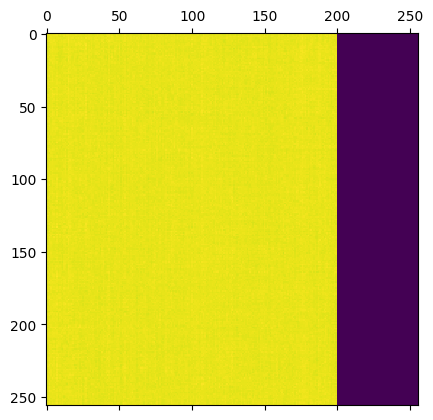

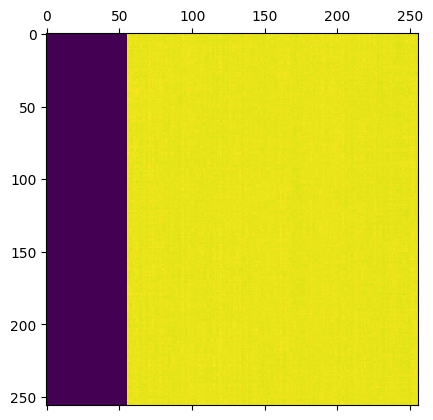

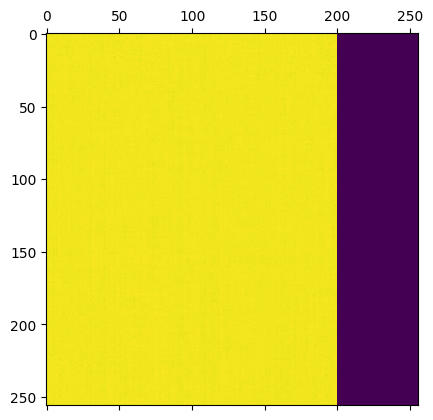

In [3]:
import matplotlib.pyplot as plt
import torch

from models import Seq2Seq

s2s = Seq2Seq()

src = torch.randint(50257, (4, 256))
trg = torch.randint(50257, (4, 256))

src_mask = torch.concat([torch.ones(4, 256, 200), torch.zeros(4, 256, 56)], dim=-1)
trg_mask = torch.flip(src_mask, dims=(-1,))

out = s2s(src, trg, source_mask=src_mask, target_mask=trg_mask)

plt.matshow(
    s2s.encoder.encoder_layers[0].multihead_self_attention.attentions[0][0].detach()
)
plt.matshow(
    s2s.decoder.decoder_layers[0].multihead_self_attention.attentions[0][0].detach()
)
plt.matshow(
    s2s.decoder.decoder_layers[0].multihead_source_attention.attentions[0][0].detach()
)


In [5]:
from data_utils import PandasDataset, tokenize

data_path = "/kaggle/input/en-fr-translation-dataset/en-fr.csv"
ds = PandasDataset(
    data_path,
    input_column="en",
    output_column="fr",
    input_transform=tokenize(100),
    output_transform=tokenize(100, padding_side="left")
)
print(ds[111])

((tensor([31310,   712, 19854,   383, 28098, 25758,   318,  4920,   287, 14074,
           11, 10553,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [6]:
from torch.utils.data import DataLoader

dl = DataLoader(ds, batch_size=64, shuffle=True)
for (src, src_mask), (trg, trg_mask) in dl:
    print(trg_mask)
    print(trg_mask.shape)
    print(trg)
    print(trg.shape)
    break

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])
torch.Size([64, 100])
tensor([[50256, 50256, 50256,  ...,   298, 28141,  1058],
        [50256, 50256, 50256,  ...,    83,  1171,    30],
        [50256, 50256, 50256,  ...,  1005, 12907,    13],
        ...,
        [50256, 50256, 50256,  ...,   972, 14644,    13],
        [   47,   454,   300,  ..., 11934,   555,  1527],
        [50256, 50256, 50256,  ...,  2634,   443, 49498]])
torch.Size([64, 100])


In [7]:
from data_utils import Gpt2Tokenizer
tok = Gpt2Tokenizer
tok.convert_ids_to_tokens([13, 24563])

['.', 'ĠNT']

In [8]:
import torch.nn as nn

num_heads = 8
d_model = 256
seq_len = 100

model = Seq2Seq(
    num_encoders = 6,
    num_decoders = 6,
    num_heads = num_heads,
    d_model = d_model,
    seq_len = seq_len
)

loss_fn = nn.CrossEntropyLoss()
lr = 0.00025  # a pretty low learning rate seems to work best
opt = torch.optim.Adam(model.parameters())#, lr=lr)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"{device=}")
model.to(device=device)

log_loss_every = 100

i = 0
for epoch in range(1):
    for (src, src_mask), (y, trg_mask) in dl:
        y = y.to(device=device)
        src = src.to(device=device)
        src_mask = src_mask.to(device=device)
        src_mask = src_mask.unsqueeze(-1) * src_mask.unsqueeze(-2)
        
        # Create target sequence (i.e. y shifted right)
        trg = torch.roll(y, 1, dims=-1)
        trg[:, 0] = 50256  # pad token
        trg = trg.to(device=device)
        trg_mask = trg_mask.to(device=device)
        trg_mask = trg_mask.unsqueeze(-1) * trg_mask.unsqueeze(-2)
        trg_mask = torch.tril(trg_mask)  # subsequent mask

        opt.zero_grad()

        out = model(src, trg, source_mask=src_mask, target_mask=trg_mask)

        loss = loss_fn(out.transpose(1, 2), y)

        loss.backward()

        opt.step()

        if i % log_loss_every == 0:
            print(f"epoch={epoch}, iter={i}, loss={loss.detach().cpu():.4f}")
        i += 1

device=device(type='cuda')
epoch=0, iter=0, loss=11.1318, 
epoch=0, iter=100, loss=3.0166, 
epoch=0, iter=200, loss=2.9664, 


KeyboardInterrupt: 

In [ ]:
out.detach().cpu()

In [ ]:
model = None
y = None
src = None
src_mask = None
trg = None
trg_mask = None